# Robustness to small sample sizes

for all methods

In [66]:
require('cowplot')
library('ggplot2')
source(file.path('..','commons','get_expected_pval_and_equiv_z.R'))
source(file.path('..','commons','multiplot.R'))
source(file.path('..','commons','plot_lib.R'))
source(file.path('..', 'commons','prepare_data.R'))
source(file.path('..', 'commons','plot_unit_mismatch.R'))
source(file.path('..', 'commons','plot_blandaldman_z.R'))
source(file.path('..', 'commons','plot_grid_methods_color_within.R'))
source(file.path('..', 'commons','plot_qq_p.R'))
theme_set(theme_gray()) # switch to default ggplot2 theme for good

## One-sample tests

### Load data from CSV

In [8]:
allsimudat_k05 <- load_data_from_csv('^test1_k005.*', '/Volumes/camille/IBMA_simu/')
allsimudat_k10 <- load_data_from_csv('^test1_k010.*', '/Volumes/camille/IBMA_simu/')
allsimudat_k25_n20 <- load_data_from_csv('^test1_k025_n20.*', '/Volumes/camille/IBMA_simu/')
allsimudat_k50 <- load_data_from_csv('^test1_k050.*', '/Volumes/camille/IBMA_simu/')
allsimudat_k25_n100 <- load_data_from_csv('^test1_k025_n100_.*', '/Volumes/camille/IBMA_simu/')

[1] "pattern= test1_k005"
[1] "CSV file /Users/cmaumet/Projects/Meta-analysis/dev/zmeta/small_samples/../data/allsimudat_test1_k005.csv  not found, reprocessing the data."
[1] "^test1_k005.*"
[1] "72 simulations"
[1] "Reading  72  /  72"
[1] "/Volumes/camille/IBMA_simu//test1_k005_n20_btw1_wthdiff16_nominal/simu_400.csv"
[1] "saved in /Users/cmaumet/Projects/Meta-analysis/dev/zmeta/small_samples/../data/allsimudat_test1_k005.csv"
[1] "Reading  71  /  72"
[1] "/Volumes/camille/IBMA_simu//test1_k005_n20_btw1_wthdiff16_datascl_soft50_002/simu_400.csv"
[1] "saved in /Users/cmaumet/Projects/Meta-analysis/dev/zmeta/small_samples/../data/allsimudat_test1_k005.csv"
[1] "Reading  70  /  72"
[1] "/Volumes/camille/IBMA_simu//test1_k005_n20_btw1_wthdiff16_datascl_soft20_002/simu_400.csv"
[1] "saved in /Users/cmaumet/Projects/Meta-analysis/dev/zmeta/small_samples/../data/allsimudat_test1_k005.csv"
[1] "Reading  69  /  72"
[1] "/Volumes/camille/IBMA_simu//test1_k005_n20_btw1_wthdiff16_contscl/simu_4

[1] "pattern= test1_k010"
[1] "CSV file /Users/cmaumet/Projects/Meta-analysis/dev/zmeta/small_samples/../data/allsimudat_test1_k010.csv  not found, reprocessing the data."
[1] "^test1_k010.*"
[1] "72 simulations"
[1] "Reading  72  /  72"
[1] "/Volumes/camille/IBMA_simu//test1_k010_n20_btw1_wthdiff16_nominal/simu_400.csv"
[1] "saved in /Users/cmaumet/Projects/Meta-analysis/dev/zmeta/small_samples/../data/allsimudat_test1_k010.csv"
[1] "Reading  71  /  72"
[1] "/Volumes/camille/IBMA_simu//test1_k010_n20_btw1_wthdiff16_datascl_soft50_002/simu_400.csv"
[1] "saved in /Users/cmaumet/Projects/Meta-analysis/dev/zmeta/small_samples/../data/allsimudat_test1_k010.csv"
[1] "Reading  70  /  72"
[1] "/Volumes/camille/IBMA_simu//test1_k010_n20_btw1_wthdiff16_datascl_soft20_002/simu_400.csv"
[1] "saved in /Users/cmaumet/Projects/Meta-analysis/dev/zmeta/small_samples/../data/allsimudat_test1_k010.csv"
[1] "Reading  69  /  72"
[1] "/Volumes/camille/IBMA_simu//test1_k010_n20_btw1_wthdiff16_contscl/simu_4

[1] "pattern= test1_k025_n20"
[1] "CSV file /Users/cmaumet/Projects/Meta-analysis/dev/zmeta/small_samples/../data/allsimudat_test1_k025_n20.csv  not found, reprocessing the data."
[1] "^test1_k025_n20.*"
[1] "72 simulations"
[1] "Reading  72  /  72"
[1] "/Volumes/camille/IBMA_simu//test1_k025_n20_btw1_wthdiff16_nominal/simu_400.csv"
[1] "saved in /Users/cmaumet/Projects/Meta-analysis/dev/zmeta/small_samples/../data/allsimudat_test1_k025_n20.csv"
[1] "Reading  71  /  72"
[1] "/Volumes/camille/IBMA_simu//test1_k025_n20_btw1_wthdiff16_datascl_soft50_002/simu_400.csv"
[1] "saved in /Users/cmaumet/Projects/Meta-analysis/dev/zmeta/small_samples/../data/allsimudat_test1_k025_n20.csv"
[1] "Reading  70  /  72"
[1] "/Volumes/camille/IBMA_simu//test1_k025_n20_btw1_wthdiff16_datascl_soft20_002/simu_400.csv"
[1] "saved in /Users/cmaumet/Projects/Meta-analysis/dev/zmeta/small_samples/../data/allsimudat_test1_k025_n20.csv"
[1] "Reading  69  /  72"
[1] "/Volumes/camille/IBMA_simu//test1_k025_n20_btw1_

[1] "pattern= test1_k050"
[1] "CSV file /Users/cmaumet/Projects/Meta-analysis/dev/zmeta/small_samples/../data/allsimudat_test1_k050.csv  not found, reprocessing the data."
[1] "^test1_k050.*"
[1] "72 simulations"
[1] "Reading  72  /  72"
[1] "/Volumes/camille/IBMA_simu//test1_k050_n20_btw1_wthdiff16_nominal/simu_400.csv"
[1] "saved in /Users/cmaumet/Projects/Meta-analysis/dev/zmeta/small_samples/../data/allsimudat_test1_k050.csv"
[1] "Reading  71  /  72"
[1] "/Volumes/camille/IBMA_simu//test1_k050_n20_btw1_wthdiff16_datascl_soft50_002/simu_400.csv"
[1] "saved in /Users/cmaumet/Projects/Meta-analysis/dev/zmeta/small_samples/../data/allsimudat_test1_k050.csv"
[1] "Reading  70  /  72"
[1] "/Volumes/camille/IBMA_simu//test1_k050_n20_btw1_wthdiff16_datascl_soft20_002/simu_400.csv"
[1] "saved in /Users/cmaumet/Projects/Meta-analysis/dev/zmeta/small_samples/../data/allsimudat_test1_k050.csv"
[1] "Reading  69  /  72"
[1] "/Volumes/camille/IBMA_simu//test1_k050_n20_btw1_wthdiff16_contscl/simu_4

[1] "pattern= test1_k025_n100_"
[1] "CSV file /Users/cmaumet/Projects/Meta-analysis/dev/zmeta/small_samples/../data/allsimudat_test1_k025_n100_.csv  not found, reprocessing the data."
[1] "^test1_k025_n100_.*"
[1] "72 simulations"
[1] "Reading  72  /  72"
[1] "/Volumes/camille/IBMA_simu//test1_k025_n100_btw1_wthdiff16_nominal/simu_400.csv"
[1] "saved in /Users/cmaumet/Projects/Meta-analysis/dev/zmeta/small_samples/../data/allsimudat_test1_k025_n100_.csv"
[1] "Reading  71  /  72"
[1] "/Volumes/camille/IBMA_simu//test1_k025_n100_btw1_wthdiff16_datascl_soft50_002/simu_400.csv"
[1] "saved in /Users/cmaumet/Projects/Meta-analysis/dev/zmeta/small_samples/../data/allsimudat_test1_k025_n100_.csv"
[1] "Reading  70  /  72"
[1] "/Volumes/camille/IBMA_simu//test1_k025_n100_btw1_wthdiff16_datascl_soft20_002/simu_400.csv"
[1] "saved in /Users/cmaumet/Projects/Meta-analysis/dev/zmeta/small_samples/../data/allsimudat_test1_k025_n100_.csv"
[1] "Reading  69  /  72"
[1] "/Volumes/camille/IBMA_simu//test1

In [9]:
allsimudat <- rbind(
                    allsimudat_k05, 
                    allsimudat_k10, 
                    allsimudat_k25_n20, 
                    allsimudat_k25_n100,
                    allsimudat_k50
)

In [18]:
unique(allsimudat$methods)

[1] fishers      stouffers    stouffersMFX weightedZ    megaRFX     
[6] permutZ      permutCon    megaMFX      megaFFX_FSL 
9 Levels: fishers megaFFX_FSL megaMFX megaRFX permutCon permutZ ... weightedZ

### Figure

In [35]:
data_positive_z <- subset(allsimudat, is.finite(expectedz) & expectedz>0)#  &  methods %in% con_methods)

data_under_rfx_assumption <- subset(data_positive_z, 
    ((methods %in% c("megaMFX") & Between==1) | 
     (methods %in% c("megaRFX") & Between==1)  |
     (methods %in% c("megaFFX_FSL") & Between==0) |
     (methods %in% c("permutCon") & Between ==1) |
     (methods %in% c("fishers") & Between==0) |
     (methods %in% c("stouffers") & Between==0) |
     (methods %in% c("stouffersMFX") & Between==1) |     
     (methods %in% c("weightedZ") & Between==0) |     
     (methods %in% c("permutZ") & Between==1)    
    ) & (unitMism=="nominal"))

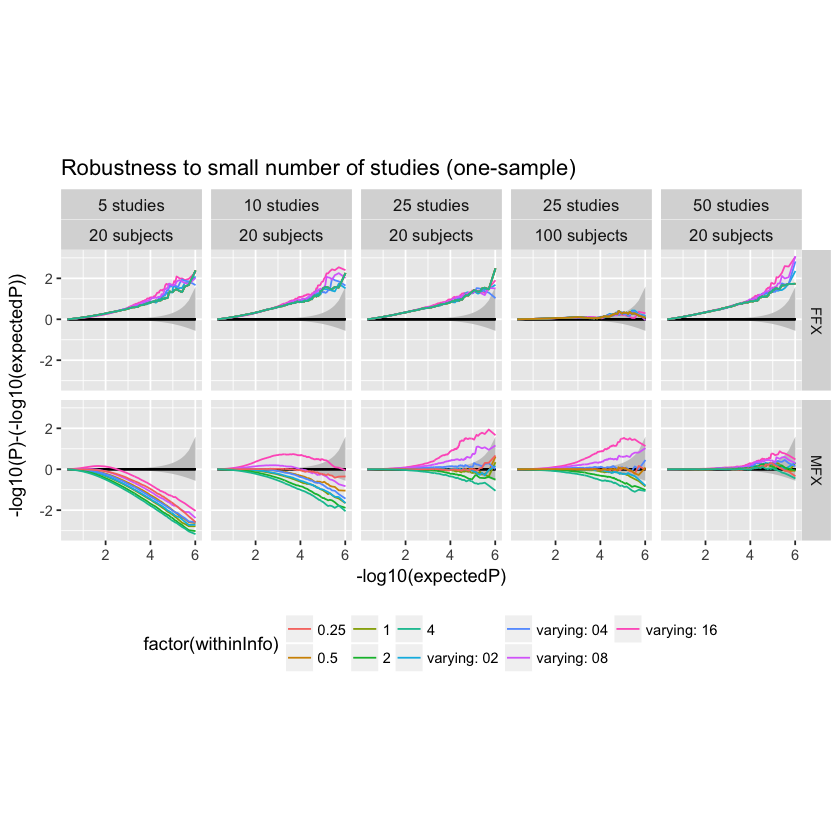

In [76]:
source(file.path('..', 'commons','plot_grid_methods_color_within.R'))
large_sample_assumptions_methods <- c("megaMFX","megaFFX_FSL")
p <- plot_qq_p(
    list(subset(data_under_rfx_assumption, methods %in% large_sample_assumptions_methods)),
    formula=methods~nStudies+nSubjects, "Robustness to small sample sizes (one-sample)", 
    mult=FALSE, lim=NA, filename='test1_smallsample_robustness')

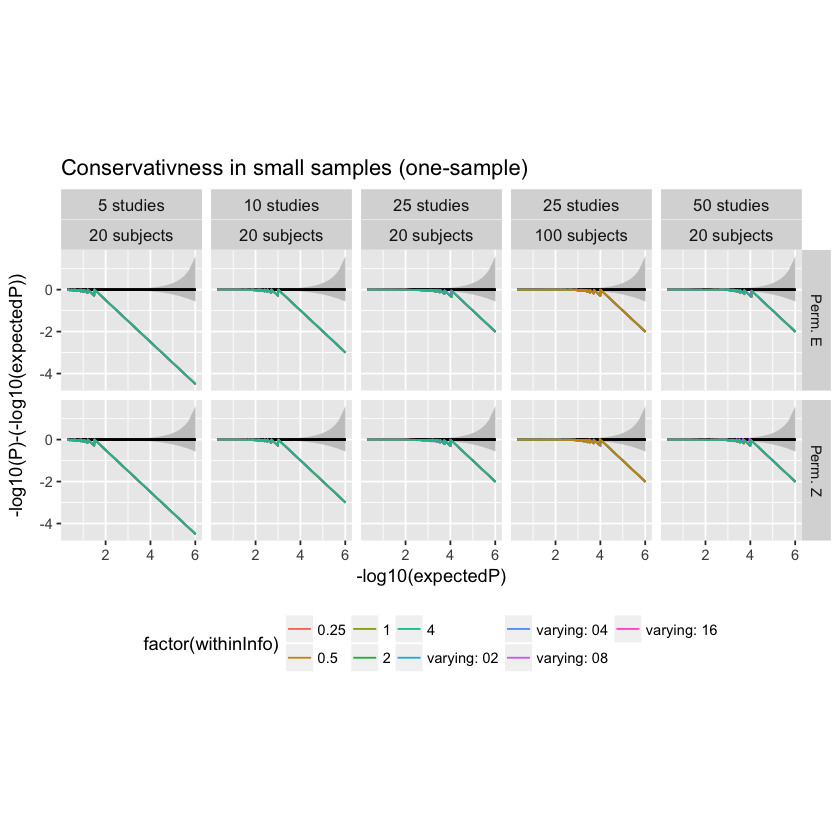

In [77]:
possibly_conservative_methods <- c("permutCon","permutZ")
p <- plot_qq_p(
    list(subset(data_under_rfx_assumption, methods %in% possibly_conservative_methods)), 
    formula=methods~nStudies+nSubjects, "Conservativness in small samples (one-sample)",
    mult=FALSE, lim=NA, filename=NA)
    

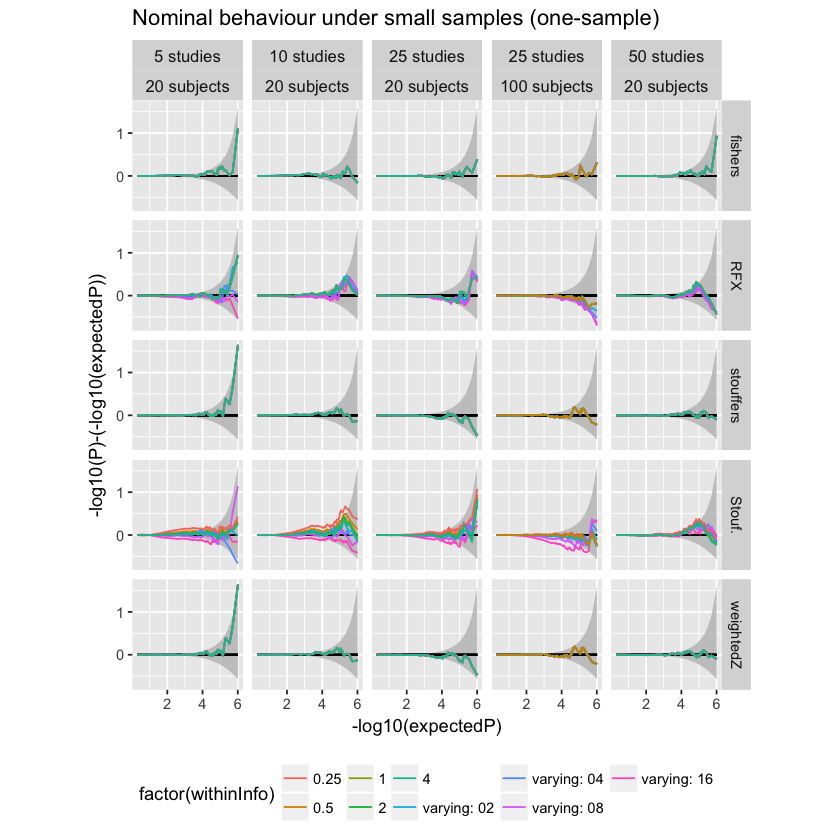

In [79]:
other_methods <- setdiff(unique(allsimudat$methods), 
                         union(large_sample_assumptions_methods, possibly_conservative_methods))
p <- plot_qq_p(
    list(subset(data_under_rfx_assumption, methods %in% other_methods)), 
    formula=methods~nStudies+nSubjects, "Nominal behaviour under small samples (one-sample)", 
    mult=FALSE, lim=NA, filename=NA)

## Two-sample tests

### Load data from CSV

In [6]:
allsimudat2_k05 <- load_data_from_csv('^test2_k005.*', '/Volumes/camille/IBMA_simu/')
allsimudat2_k25_n20 <- load_data_from_csv('^test2_k025_n20.*', '/Volumes/camille/IBMA_simu/')
allsimudat2_k50 <- load_data_from_csv('^test2_k050.*', '/Volumes/camille/IBMA_simu/')
allsimudat2_k25_n100 <- load_data_from_csv('^test2_k025_n100_.*', '/Volumes/camille/IBMA_simu/')

[1] "Reading from  /Users/cmaumet/Projects/Meta-analysis/dev/zmeta/small_samples/../data/allsimudat_test2_k005.csv"
[1] "Reading from  /Users/cmaumet/Projects/Meta-analysis/dev/zmeta/small_samples/../data/allsimudat_test2_k025_n20.csv"
[1] "pattern= test2_k050"
[1] "CSV file /Users/cmaumet/Projects/Meta-analysis/dev/zmeta/small_samples/../data/allsimudat_test2_k050.csv  not found, reprocessing the data."
[1] "^test2_k050.*"
[1] "19 simulations"
[1] "Reading  19  /  19"
[1] "/Volumes/camille/IBMA_simu//test2_k050_n20_btw0_wthdiff04_datascl_soft50_002/simu_400.csv"
[1] "/!  /Volumes/camille/IBMA_simu//test2_k050_n20_btw0_wthdiff04_datascl_soft50_002/simu_400.csv does not exist."
[1] "Reading  18  /  19"
[1] "/Volumes/camille/IBMA_simu//test2_k050_n20_btw0_wthdiff04_datascl_soft20_002/simu_400.csv"
[1] "/!  /Volumes/camille/IBMA_simu//test2_k050_n20_btw0_wthdiff04_datascl_soft20_002/simu_400.csv does not exist."
[1] "Reading  17  /  19"
[1] "/Volumes/camille/IBMA_simu//test2_k050_n20_btw0

Warning message in file(file, "rt"):
“cannot open file '/Users/cmaumet/Projects/Meta-analysis/dev/zmeta/small_samples/../data/allsimudat_test2_k050.csv': No such file or directory”

ERROR: Error in file(file, "rt"): cannot open the connection


In [ ]:
allsimudat2 <- rbind(
                    allsimudat2_k05, 
                    allsimudat2_k25_n20, 
                    allsimudat2_k25_n100,
                    allsimudat2_k50
)

In [ ]:
z_methods <- c("fishers", "stouffers", "stouffersMFX", "weightedZ", "permutZ")
con_data_1 <- subset(allsimudat, is.finite(expectedz) & expectedz>0  &  methods %in% z_methods)

best_con_data_1 <- subset(con_data_1, 
    ((methods %in% c("fishers") & Between==0) | 
     (methods %in% c("stouffers") & Between==0)  |
     (methods %in% c("stouffersMFX") & Between==1)  |
     (methods %in% c("weightedZ") & Between==0) |
     (methods %in% c("permutZ") & Between==1)
    ) & (unitMism=="nominal"))

best_con_data_1_n20 <- subset(best_con_data_1, nSubjects==20)
best_con_data_1_n50 <- subset(best_con_data_1, nSubjects==50)
best_con_data_1_n100_k100 <- subset(best_con_data_1, nSubjects==100)


p <- plot_blandaldman_z(
    list(best_con_data_1), 
    formula=methods~unitMism+nStudies+nSubjects, 
    title="Bland-Altman Z-plots",
    mult=FALSE, 
    lim=NA, max_z=18, filename=NA)
p <- plot_qq_p(
    list(best_con_data_1), 
    formula=methods~unitMism+nStudies+nSubjects, 
    "Bland-Altman QQ-plots", 
    mult=FALSE, 
    lim=NA, max_z=18, filename=NA)

In [ ]:
z_methods <- c("fishers", "stouffers", "stouffersMFX", "weightedZ", "permutZ")
con_data_1 <- subset(allsimudat, is.finite(expectedz) & expectedz>0  &  methods %in% z_methods)

best_con_data_1 <- subset(con_data_1, 
    ((methods %in% c("fishers") & Between==1) | 
     (methods %in% c("stouffers") & Between==1)  |
     (methods %in% c("stouffersMFX") & Between==1)  |
     (methods %in% c("weightedZ") & Between==1) |
     (methods %in% c("permutZ") & Between==1)
    ) & (unitMism=="nominal"))

best_con_data_1_n20 <- subset(best_con_data_1, nSubjects==20)
best_con_data_1_n50 <- subset(best_con_data_1, nSubjects==50)
best_con_data_1_n100_k100 <- subset(best_con_data_1, nSubjects==100)


p <- plot_blandaldman_z(
    list(best_con_data_1), 
    formula=methods~unitMism+nStudies+nSubjects, 
    title="Bland-Altman Z-plots",
    mult=FALSE, 
    lim=NA, max_z=18, filename=NA)
p <- plot_qq_p(
    list(best_con_data_1), 
    formula=methods~unitMism+nStudies+nSubjects, 
    "Bland-Altman QQ-plots", 
    mult=FALSE, 
    lim=NA, max_z=18, filename=NA)

In [ ]:
unique(allsimudat$methods)